# <span style="color: blue;">ให้กรอกรหัสนิสิต และชื่อ-นามสกุลของสมาชิกในทีม</span>
# <span style="color: blue;">(ห้ามมีสมาชิกเกิน 2 คน)</span>
## รหัสนิสิต ชื่อ-นามสกุล
<span style="color: green;">6714450249 นายหรินทร์ ธนะนาม</span>

## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import os

# must come *before* any Tensorflow import
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[]

In [42]:
tf.test.gpu_device_name()

''

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# The data, shuffled and split between train and test sets:
(_x_train, _y_train), (_x_test, _y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = (_x_train, _y_train), (_x_test, _y_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


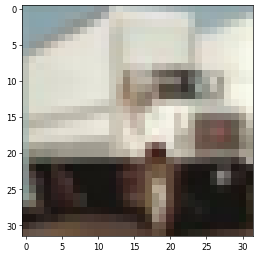

In [7]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])

plt.figure(figsize=(5, 5), dpi=60)
plt.imshow(x_train[image_no])
plt.show()

In [8]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [10]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## <span style="color:red"> เพื่อป้องกันผลกระทบจากการสุ่ม (randomness) ให้ใช้ค่า seed เป็น 12345 โดยให้เรียกใช้ฟังก์ชัน set_seed(12345) ทุกครั้งก่อนที่จะสร้างโมเดล และให้กำหนดค่า seed ด้วยในการแบ่งข้อมูล </span>
## <span style="color:red"> นอกจากนี้ ห้ามใช้ Early Stopping หรือใช้ Best Weights ในการเทรนโมเดล </span>

## <span style="color:blue"> ส่วนการแบ่งข้อมูล </span>

## <span style="color:green"> 1. (20 คะแนน) ให้แบ่งชุดข้อมูล train ออกเป็น 2 ส่วนในอัตราส่วน 90:10 และข้อมูลทั้ง 2 ส่วนนี้ให้แต่ละคลาสมีจำนวนข้อมูลเท่ากัน โดยข้อมูลที่ถูกแบ่งให้เก็บอยู่ในชุดข้อมูลที่เป็น train และ val ตามลำดับ หลังจากที่แบ่งข้อมูลเสร็จ ให้แสดงจำนวนข้อมูลของแต่ละคลาสในชุดข้อมูล train และ val </span>

In [11]:
seed_value = 12345

In [12]:
# Split train data set into 2 part 90:10
from sklearn.model_selection import train_test_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train,
    y_train,
test_size=0.1,                              # 90% train, 10% validation
    random_state=seed_value,                # Force same result every time
    stratify=np.argmax(y_train, axis=1)     # Make sure every class have same ratio (Benefit for 1x1 dimension array not for matrix array)
)

In [13]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('--------------------------------')
print('x_train size:', x_train_split.shape[0])
print('x_test size:', x_val_split.shape[0])
print('y_train size:', y_train_split.shape[0])
print('y_train size:', y_val_split.shape[0])

50000 train samples
10000 test samples
--------------------------------
x_train size: 45000
x_test size: 5000
y_train size: 45000
y_train size: 5000


## <span style="color: yellow;">คำตอบ</span>
จากชุดข้อมูล train ที่มีทั้งหมด 50,000 ตัวอย่าง เมื่อแบ่งข้อมูลให้ออกเป็น 2 ส่วนในอัตราส่วน 90:10
หมายความว่าในชุดข้อมูล train จะต้องได้ 90% จากชุดข้อมูลเดิมคือ 45,000 และในชุดข้อมูล val จะต้องได้ 10% จากชุดข้อมูลเดิมคือ 5,000
สามารถทำได้ด้วยการใช้คำสั่ง train_test_split

```python
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train,
    y_train,
    test_size=0.1,            # 90% train, 10% validation
    random_state=seed_value,  # Force same result every time
    stratify=y_train          # Make sure every class have same ratio
)
```
**x_train** และ **y_train** คือ dataset ที่เป็น Input
**test_size=0.1** หมายถึงให้ตัดแบ่งชุดข้อมูลเป็น test ไป 0.1 หรือก็คือ 10% จาก Input
ดังนั้น ชุดข้อมูล train ที่จะได้คือ 90% ของ Input
**random_state** ใส่เพื่อให้ได้ผลลัพธ์เหมือนกันทุกครั้ง ในที่นี้คือ 12345 (ตั้งใจใช้ค่าเดียวกันกับ seed_value)
stratify=y_train เพื่อให้การแบ่งข้อมูยังมีสัดส่วนเท่าเดิม

## <span style="color:blue"> ส่วนการเทรนโมเดล </span>

In [14]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()

## 5x5 convolution with 1x1 stride and 16 filters
model_1.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same',
                   input_shape=x_train.shape[1:], activation='relu',
                   name='conv_1'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='valid', 
                   activation='relu', name='conv_2'))

## 2x2 max pooling reduces to 7 x 7 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2), name='pool_1'))

## Flatten turns 7x7x32 into 1568x1
model_1.add(Flatten(name='flatten_1'))
model_1.add(Dense(64, activation='relu', name='dense_1'))
model_1.add(Dense(num_classes, activation='softmax', name='dense_2'))

model_1.summary()

C:\Users\User\.conda\envs\deep-learning-application\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,114 (449.66 KB)

 Trainable params: 115,114 (449.66 KB)

 Non-trainable params: 0 (0.00 B)

## <span style="color:green"> 2. (20 คะแนน) ให้ใช้ชุดข้อมูล train และ val เพื่อเทรนโมเดล model_1 ตามที่กำหนดโครงสร้างไว้ให้ด้านบน โดยให้ใช้จำนวน epoch ไม่น้อยกว่า 20 รอบ หลังจากเทรนโมเดลเสร็จ ให้แสดงกราฟ Loss และ Accuracy พร้อมแสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train และ val </span>

In [15]:
print("Number of classes: ", num_classes)
print("Classes values: ", np.unique(y_train))

Number of classes:  10
Classes values:  [0. 1.]


In [16]:
set_seed(12345)

from tensorflow.keras.optimizers import Adam
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(x_train_split, y_train_split, validation_data=(x_val_split, y_val_split), epochs=30, batch_size=32)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2701 - loss: 2.0102 - val_accuracy: 0.4314 - val_loss: 1.6205
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4452 - loss: 1.5769 - val_accuracy: 0.4856 - val_loss: 1.4798
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4876 - loss: 1.4456 - val_accuracy: 0.5098 - val_loss: 1.3873
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5193 - loss: 1.3531 - val_accuracy: 0.5324 - val_loss: 1.3285
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5430 - loss: 1.2881 - val_accuracy: 0.5460 - val_loss: 1.2827
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5635 - loss: 1.2366 - val_accuracy: 0.5536 - val_loss: 1.2463
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5799 - loss: 1.1931 - val_accuracy: 0.5620 - val_loss: 1.2157
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5930 - loss: 1.1549 

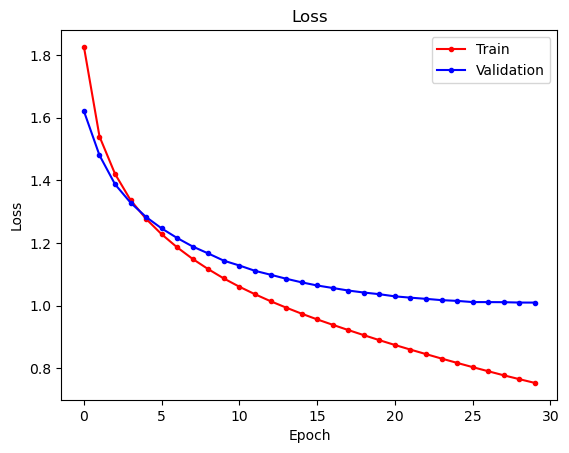

In [17]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation")
ax.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

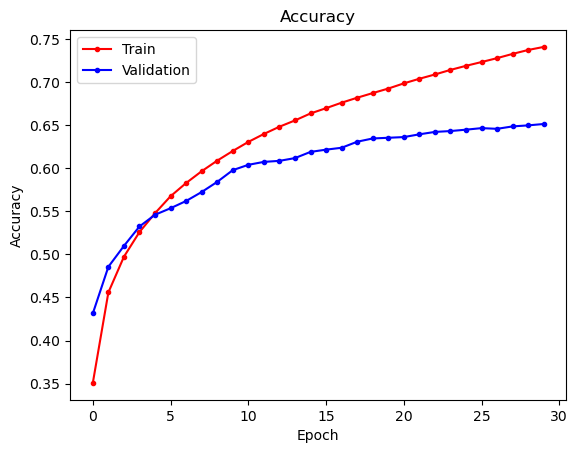

In [18]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["accuracy"],'r', marker='.', label="Train")
ax.plot(run_hist_1.history["val_accuracy"],'b', marker='.', label="Validation")
ax.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [28]:
loss_train, accuracy_train = model_1.evaluate(x_train_split, y_train_split)
loss_val, accuracy_val = model_1.evaluate(x_val_split, y_val_split)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7413 - loss: 0.7515
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6642 - loss: 0.9941


In [30]:
print('Training Accuracy: {:.4f}'.format(accuracy_train))
print('Training Loss: {:.4f}'.format(loss_train))
print('Validation Accuracy: {:.4f}'.format(accuracy_val))
print('Validation Loss: {:.4f}'.format(loss_val))

Training Accuracy: 0.7399
Training Loss: 0.7487
Validation Accuracy: 0.6514
Validation Loss: 1.0096


## <span style="color: yellow;">คำตอบ</span>
ก่อนที่เราจะทำการ Train Model จำเป็นที่จะต้องตั้งค่าวิธีการเรียนรู้ก่อน จึงจำเป็นที่จะต้องใช้คำสั่ง `compile()` ด้วยคำสั่งด้านล่างนี้
```python
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
```

- `optimizer` คือ Algorithm วิธีการเรียนรู้ของ Model ในที่นี้เลือกใช้ Adam เนื่องจากว่าเป็นที่นิยมในการหยิบมาใช้ทำกับงานประเภทรูปภาพ
- `loss` คือ จุดที่กำหนด Loss Function ที่จะไว้ใช้ในการประเมินผลว่า Model ทำงานได้ดีแค่ไหน โดยติจะมี `binary_crossentropy`,`categorical_crossentropy`ซึ่งในที่นี้เลือกใช้ `categorical_crossentropy` เนื่องจากว่าเป็นการจำแนกประเภทที่มีมากกว่า 2 Class

จากนั้นจึงทำการใช้คำสั่ง `fit()` เพื่อทำการ Train Model โดยใช้ข้อมูลที่แบ่งไว้เป็น train และ val ดังนี้
```python
run_hist_1 = model_1.fit(x_train_split, y_train_split, validation_data=(x_val_split, y_val_split), epochs=30, batch_size=32)
```
ผลลัพธ์ที่ได้จากคำสั่งจะเป็นข้อมูลที่บอกว่า Model ทำงานได้ดีระดับไหน สำหรับ Model นี้จะได้ผลว่า
| #          | Loss   | Accuracy |
|------------|--------|----------|
| Training   | 0.7637 | 0.7370   |
| Validation | 1.0333 | 0.6532   |

## <span style="color:green"> 3. (30 คะแนน) ให้แสดงตารางภาพ Confusion Matrix และ Classification Report (ดังตัวอย่างในรูป) จากผลการทำนายของโมเดลด้วยข้อมูล test </span>
![Classification Report](https://drive.google.com/thumbnail?id=1f6Hh-LNsj7mWdNsyT3LRPxAcy73Oa6c_&sz=h360)

$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$


$
\begin{align}
&\text{where TP: True Positives, TN: True Negatives, FP: False Positives, and FN: False Negatives}
\end{align}
$

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.71      0.68      0.69      1000
  automobile       0.76      0.74      0.75      1000
        bird       0.48      0.64      0.54      1000
         cat       0.49      0.49      0.49      1000
        deer       0.70      0.44      0.54      1000
         dog       0.57      0.54      0.55      1000
        frog       0.75      0.70      0.73      1000
       horse       0.73      0.71      0.72      1000
        ship       0.75      0.80      0.77      1000
       truck       0.67      0.77      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



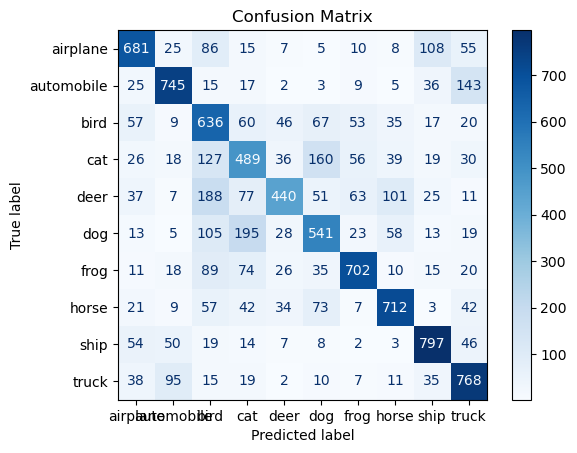

In [31]:
# Used sklern to generate classification report and confusion matrix
plt.close('all')
y_pred = model_1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=class_names))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

## <span style="color:green"> 4. (30 คะแนน) ให้สร้างโมเดลใหม่ที่มีโครงสร้างซับซ้อนมากขึ้น โดยสามารถใช้รูปแบบโครงสร้างดังนี้ </span>

~~~python
Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classifier
(ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional)
~~~

## <span style="color:green"> และให้เทรนโมเดลใหม่เพื่อให้ได้ accuracy ที่ดีขึ้นจากชุดข้อมูล test ซึ่งในการเทรนนี้ ให้ใช้จำนวน epoch ไม่น้อยกว่า 20 รอบ โดยหลังจากเทรนโมเดลเสร็จ ให้แสดง </span>
### * <span style="color:green"> กราฟ Loss และ Accuracy พร้อมแสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train และ val </span>
### * <span style="color:green"> ตารางภาพ Confusion Matrix และ Classification Report จากผลการทำนายของโมเดลด้วยข้อมูล test </span>
### * <span style="color:green"> ภาพที่โมเดลใหม่ทำนายผิดของคลาสที่มี f1-score สูงสุดมาอย่างน้อย 3 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร </span>

In [33]:
# Use Accuracy from train from this model vs previous model
set_seed(12345)
model_2 = Sequential()

model_2.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same',
                   input_shape=x_train.shape[1:], activation='relu', name='conv_1'))
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_2'))
model_2.add(MaxPooling2D(pool_size=(2, 2), name='pool_1'))

model_2.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same' , activation='relu', name='conv_3'))
model_2.add(Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_4'))
model_2.add(MaxPooling2D(pool_size=(2, 2), name='pool_2'))

## Flatten turns 7x7x32 into 1568x1
model_2.add(Flatten(name='flatten_1'))
model_2.add(Dense(64, activation='relu', name='dense_1'))
model_2.add(Dense(num_classes, activation='softmax', name='output'))

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 795,242 (3.03 MB)

 Trainable params: 795,242 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
set_seed(12345)

from tensorflow.keras.optimizers import Adam
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(x_train_split, y_train_split, validation_data=(x_val_split, y_val_split), epochs=30, batch_size=32)

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation")
ax.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["accuracy"],'r', marker='.', label="Train")
ax.plot(run_hist_2.history["val_accuracy"],'b', marker='.', label="Validation")
ax.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print('Training Accuracy: {:.4f}'.format(run_hist_2.history["accuracy"][-1]))
print('Validation Accuracy: {:.4f}'.format(run_hist_2.history["val_accuracy"][-1]))
print('Training Loss: {:.4f}'.format(run_hist_2.history["loss"][-1]))
print('Validation Loss: {:.4f}'.format(run_hist_2.history["val_loss"][-1]))

In [ ]:
plt.close('all')
y_pred_2 = model_2.predict(x_test)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)
y_true_2 = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes_2, target_names=class_names))
cm_2 = confusion_matrix(y_true, y_pred_classes_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=class_names)
disp_2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_class = 'automobile'

incorrect_indices = np.where(
    (y_true_2 == class_names.index (best_class))
    & (y_pred_classes_2 != class_names.index(best_class))
)[0]

for i in range(min(3, len(incorrect_indices))):
    idx = incorrect_indices[i]
    plt.figure(figsize=(5, 5), dpi=60)
    plt.imshow(x_test[idx])
    plt.title(f"True: {class_names[y_true_2[idx]]}, Predicted: {class_names[y_pred_classes_2[idx]]}")
    plt.axis('off')
    plt.show()